In [1]:
%config Completer.use_jedi = False


In [2]:
import pandas as pd

import datetime as dt

import nsepy

from Dashboards.helpers.nse import nse_load_options, load_underlying

from Dashboards.helpers.probability import calculate_period_delta, evaluate_pairs, generate_pairs

In [3]:
underlying = 'NIFTY'
data_df, expiries = nse_load_options(underlying)

## Unrealizesed PNL Report

In [4]:
positions_df = pd.read_excel('Data/unrealizedPnl_report_2122_Future & Options.xlsx', skiprows=5, header=1)
positions_df

,Scrip Name,Scrip Code,Unrealized P&L,Unrealized P&L %,ISIN,Scrip Opt,Buy/Sell,Open Qty,Avg Rate,Open Amt,Closing Rate Exchange,Closing Rate Date,Closing Rate,Closing Amt
0,BANKNIFTY,BANKNIFTY,-1505.00,-11.4634,NaN,CE,Buy,25,₹ 525.15,"₹ 13,128.75",FON,03/12/2021,464.95,"₹ 11,623.75"
1,BANKNIFTY,BANKNIFTY,-5886.25,-33.3972,NaN,PE,Buy,25,₹ 705.00,"₹ 17,625.00",FON,03/12/2021,469.55,"₹ 11,738.75"
2,NIFTY,NIFTY,45.00,0.5982,NaN,CE,Buy,50,₹ 150.45,"₹ 7,522.50",FON,03/12/2021,151.35,"₹ 7,567.50"
3,NIFTY,NIFTY,-4332.50,-41.0664,NaN,CE,Buy,50,₹ 211.00,"₹ 10,550.00",FON,03/12/2021,124.35,"₹ 6,217.50"
4,NIFTY,NIFTY,-3485.00,-36.9369,NaN,CE,Buy,100,₹ 94.35,"₹ 9,435.00",FON,03/12/2021,59.50,"₹ 5,950.00"
5,NIFTY,NIFTY,1422.50,44.3146,NaN,PE,Buy,50,₹ 64.20,"₹ 3,210.00",FON,03/12/2021,92.65,"₹ 4,632.50"
6,NIFTY,NIFTY,-225.00,-4.8387,NaN,PE,Buy,50,₹ 93.00,"₹ 4,650.00",FON,03/12/2021,88.50,"₹ 4,425.00"
7,NIFTY,NIFTY,-1410.00,-14.8813,NaN,PE,Buy,50,₹ 189.50,"₹ 9,475.00",FON,03/12/2021,161.30,"₹ 8,065.00"
8,NIFTY,NIFTY,3875.00,53.1550,NaN,PE,Buy,50,₹ 145.80,"₹ 7,290.00",FON,03/12/2021,223.30,"₹ 11,165.00"


## Trades Report

In [228]:
# Skip the first few lines it contains the letterhead
trades_df = pd.read_excel('Data/trade_report_2122_NSE FO.xlsx', skiprows=5, header=1)

trades_df['Date'] = pd.to_datetime(trades_df['Date'], dayfirst=True)
trades_df['Expiry'] = pd.to_datetime(trades_df['Expiry'], dayfirst=True)

# Remove the Rupee symbol, and replace the comma before converting it to float
trades_df['Price'] = pd.to_numeric(trades_df['Price'].apply(lambda x: x[3:].replace(',', '')))

trades_df['option_type'] = trades_df['Instrument Type'].str[9:].replace({'Put':'PE', 
                                                                         'Call':'CE'})

trades_df.loc[trades_df['Side']=='Sell', 'Quantity']*=-1

trades_df['option_id'] = trades_df.Company + trades_df.Strike.apply(lambda strike: "%.0f"%strike) + trades_df.option_type + trades_df.Expiry.dt.strftime('_%d-%b')

In [230]:
trades_df

,Date,Company,Amount,Segment,Scrip Code,Instrument Type,Strike,Expiry,Trade Num,Trade Time,Side,Quantity,Price,option_type,option_id
0,2021-12-16,BANKNIFTY,₹ 400.00,NSE FO,BANKNIFTY,European Call,37400.0,2021-12-16,404045313,10:35:01,Sell,-25.0,16.00,CE,BANKNIFTY37400CE_16-Dec
1,2021-12-10,NIFTY,"₹ 7,700.00",NSE FO,NIFTY,European Call,17550.0,2021-12-23,100312687,11:13:01,Buy,50.0,154.00,CE,NIFTY17550CE_23-Dec
2,2021-12-10,NIFTY,"₹ 7,710.00",NSE FO,NIFTY,European Call,17550.0,2021-12-23,100311847,11:12:21,Buy,50.0,154.20,CE,NIFTY17550CE_23-Dec
3,2021-12-10,NIFTY,"₹ 10,232.50",NSE FO,NIFTY,European Put,17500.0,2021-12-23,100316143,11:15:29,Buy,50.0,204.65,PE,NIFTY17500PE_23-Dec
4,2021-12-10,NIFTY,"₹ 10,237.50",NSE FO,NIFTY,European Put,17500.0,2021-12-23,100316144,11:15:29,Buy,50.0,204.75,PE,NIFTY17500PE_23-Dec
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,2021-11-18,BANKNIFTY,"₹ 8,330.00",NSE FO,BANKNIFTY,European Call,38100.0,2021-11-25,702304153,15:18:41,Buy,25.0,333.20,CE,BANKNIFTY38100CE_25-Nov
66,2021-11-18,NIFTY,₹ 70.00,NSE FO,NIFTY,European Call,18100.0,2021-11-18,8464432,12:11:16,Sell,-50.0,1.40,CE,NIFTY18100CE_18-Nov
67,2021-11-18,NIFTY,₹ 50.00,NSE FO,NIFTY,European Call,18350.0,2021-11-18,7759277,11:49:37,Sell,-50.0,1.00,CE,NIFTY18350CE_18-Nov
68,2021-11-18,NIFTY,"₹ 6,350.00",NSE FO,NIFTY,European Put,17850.0,2021-11-18,7881893,11:53:36,Sell,-50.0,127.00,PE,NIFTY17850PE_18-Nov


**Convert Trades into open positions**

In [242]:
positions = {}
position_costs = {}
for ix, trade in trades_df.sort_values('Date', ascending=False).iterrows():
    option_id = trade.option_id
    
    if option_id not in positions:
#         if trade.Quantity > 0:
        positions[option_id] = trade.Quantity
        position_costs[option_id] = trade.Quantity*trade.Price
        
    else:
        positions[option_id] += trade.Quantity
        position_costs[option_id] += trade.Quantity*trade.Price
        if positions[option_id]==0:
            positions.pop(option_id)
            position_costs.pop(option_id)
    

positions_df = pd.DataFrame({"option_id":positions.keys(), "qty":positions.values(), "cost":position_costs.values()})

positions_df['avg_price'] = positions_df.cost/positions_df.qty

positions_df = pd.merge(trades_df[['Company', 'Strike','Expiry', 'option_type', 'option_id']].drop_duplicates(), positions_df, on='option_id', how='right')

positions_df.columns = map(str.lower, positions_df.columns)

positions_df = positions_df[positions_df.qty>0]

positions_df = positions_df[positions_df.expiry>dt.datetime.today()]

positions_df['lot_size'] = 0
positions_df['last_price'] = 0

# Update the current value of positions
for contract_row in positions_df[['company', 'expiry', 'option_type', 'strike', 'lot_size']].iterrows():
    contract = contract_row[1]
    contract_quote = nsepy.get_quote(symbol=contract['company'], series='EQ', instrument='OPTIDX', expiry=contract.expiry, strike=contract.strike, option_type=contract.option_type)
    positions_df.loc[contract_row[0], 'lot_size'] = float(contract_quote['data'][0]['marketLot'])
    positions_df.loc[contract_row[0], 'last_price'] = float(contract_quote['data'][0]['lastPrice'])

NameError: name 'nsepy' is not defined

In [243]:
positions_df

,company,strike,expiry,option_type,option_id,qty,cost,avg_price,lot_size,last_price
0,NIFTY,17500.0,2021-12-23,PE,NIFTY17500PE_23-Dec,100.0,20470.0,204.70,50,453.40
1,NIFTY,17550.0,2021-12-23,CE,NIFTY17550CE_23-Dec,100.0,15410.0,154.10,50,15.05
2,NIFTY,17600.0,2021-12-23,CE,NIFTY17600CE_23-Dec,50.0,7727.5,154.55,50,11.65
4,NIFTY,17400.0,2021-12-23,PE,NIFTY17400PE_23-Dec,50.0,8650.0,173.00,50,366.20


In [244]:
positions_df = positions_df.rename({'company':'underlying', 
                                    'strike':'strike_price'},
                                   axis=1)

In [245]:
positions_df['cost'] = positions_df.qty*positions_df.avg_price

positions_df['value'] = positions_df.qty*positions_df.last_price

In [246]:
positions_df = positions_df[positions_df.expiry>dt.datetime.today()]

In [247]:
positions_df.sort_values('strike_price')

,underlying,strike_price,expiry,option_type,option_id,qty,cost,avg_price,lot_size,last_price,value
4,NIFTY,17400.0,2021-12-23,PE,NIFTY17400PE_23-Dec,50.0,8650.0,173.00,50,366.20,18310.0
0,NIFTY,17500.0,2021-12-23,PE,NIFTY17500PE_23-Dec,100.0,20470.0,204.70,50,453.40,45340.0
1,NIFTY,17550.0,2021-12-23,CE,NIFTY17550CE_23-Dec,100.0,15410.0,154.10,50,15.05,1505.0
2,NIFTY,17600.0,2021-12-23,CE,NIFTY17600CE_23-Dec,50.0,7727.5,154.55,50,11.65,582.5


In [248]:
target_rate = 1.1

## Positions by Underlying

In [249]:
positions_by_underlying = positions_df.groupby(['underlying']).agg(qty=pd.NamedAgg(column="qty", aggfunc="sum"),  
                                                                   lot_size=pd.NamedAgg(column="lot_size", aggfunc="first"),
                                                                   current_value=pd.NamedAgg(column="value", aggfunc="sum"),
                                                                   initial_investment=pd.NamedAgg(column="cost", aggfunc="sum") ).reset_index()

positions_by_underlying['num_pairs'] = positions_by_underlying.qty/positions_by_underlying.lot_size/2

positions_by_underlying['target'] = target_rate*positions_by_underlying['initial_investment']/positions_by_underlying['qty']

# positions_by_underlying['current_value'] = positions_by_underlying['current_value']*positions_by_underlying['qty']


positions_by_underlying['change'] = (positions_by_underlying['current_value']-positions_by_underlying['initial_investment'])/positions_by_underlying['initial_investment']

positions_by_underlying

,underlying,qty,lot_size,current_value,initial_investment,num_pairs,target,change
0,NIFTY,300.0,50,65737.5,52257.5,3.0,191.610833,0.257953


## Positions by Underlying and Expiry

In [250]:
positions_by_expiry = positions_df.groupby(['underlying', 'expiry']).agg(qty=pd.NamedAgg(column="qty", aggfunc="sum"),  
                                                                         lot_size=pd.NamedAgg(column="lot_size", aggfunc="first"),
                                                                         current_value=pd.NamedAgg(column="value", aggfunc="sum"),
                                                                         initial_investment=pd.NamedAgg(column="cost", aggfunc="sum") ).reset_index()

# positions_by_expiry['target'] = target_rate*positions_by_expiry.initial_investment/positions_by_expiry.qty

positions_by_expiry['num_pairs'] = positions_by_expiry.qty/positions_by_expiry.lot_size/2


# positions_by_expiry['current_value'] = positions_by_expiry['current_value']*positions_by_expiry['qty']

# positions_by_expiry['target'] = target_rate*positions_by_expiry['initial_investment']/positions_by_expiry['num_pairs']/positions_by_expiry.lot_size


positions_by_expiry['target'] = target_rate*positions_by_expiry['initial_investment']/(positions_by_expiry['qty']/2)

positions_by_expiry['change'] = (positions_by_expiry['current_value']-positions_by_expiry['initial_investment'])/positions_by_expiry['initial_investment']

positions_by_expiry

,underlying,expiry,qty,lot_size,current_value,initial_investment,num_pairs,target,change
0,NIFTY,2021-12-23,300.0,50,65737.5,52257.5,3.0,383.221667,0.257953


## Positions by Pairs

In [241]:
positions_df

,underlying,strike_price,expiry,option_type,option_id,qty,cost,avg_price,lot_size,last_price,value
0,NIFTY,17500.0,2021-12-23,PE,NIFTY17500PE_23-Dec,100.0,20470.0,204.70,50,421.65,42165.0
1,NIFTY,17550.0,2021-12-23,CE,NIFTY17550CE_23-Dec,100.0,15410.0,154.10,50,16.75,1675.0
2,NIFTY,17600.0,2021-12-23,CE,NIFTY17600CE_23-Dec,50.0,7727.5,154.55,50,12.65,632.5
4,NIFTY,17400.0,2021-12-23,PE,NIFTY17400PE_23-Dec,50.0,8650.0,173.00,50,335.05,16752.5


In [220]:
for u, e in positions_df[['underlying', 'expiry']].drop_duplicates().to_dict(orient='split')['data']:
    position_group = positions_df[(positions_df['underlying'] == u) & (positions_df['expiry'] == e)]

    # Separate out Call and Put option
    ce_positions = position_group[position_group['option_type']=='CE']
    pe_positions = position_group[position_group['option_type']=='PE']

    # Convert to dict for easier iteration
    pe_positions = pe_positions.sort_values(by='strike_price', ascending=False).to_dict(orient='records')
    ce_positions = ce_positions.sort_values(by='strike_price').to_dict(orient='records')

    position_pairs = []

    for pe_position in pe_positions:
        for ce_position in ce_positions:
            print(ce_position['option_id'],pe_position['option_id'])

NIFTY17550CE_23-Dec NIFTY17500PE_23-Dec
NIFTY17600CE_23-Dec NIFTY17500PE_23-Dec
NIFTY17550CE_23-Dec NIFTY17400PE_23-Dec
NIFTY17600CE_23-Dec NIFTY17400PE_23-Dec
BANKNIFTY37400CE_16-Dec BANKNIFTY37100PE_16-Dec
BANKNIFTY37400CE_16-Dec BANKNIFTY36400PE_16-Dec
NIFTY17400CE_16-Dec NIFTY16850PE_16-Dec


In [14]:
DATA_ROOT = 'QmVmo99nn2wMjShNGi5CDPEqzRWtYxWRrjD5XTsfQiCZD3'

In [19]:
underlying_df = load_underlying(u, DATA_ROOT)

In [71]:
delta_df = calculate_period_delta(underlying_df, 5)
delta_df

,delta,delta_max,delta_min
Date,,,
2018-01-08,0.017372,0.014665,-0.006958
2018-01-09,0.018558,0.016837,-0.005066
2018-01-10,0.012128,0.018124,-0.002670
2018-01-11,0.008746,0.012374,-0.001343
2018-01-12,0.005427,0.009319,-0.000297
...,...,...,...
2021-11-23,-0.022085,0.004643,-0.040316
2021-11-23,-0.014717,0.003077,-0.037699
2021-11-24,-0.000086,0.000506,-0.032600


In [72]:
def evaluate_postions(options_data, underlying_period_delta, underlying_price, expected_rate=0.1):
    # Separate out Call and Put option
    ce_df = options_data[options_data['option_type']=='CE']
    pe_df = options_data[options_data['option_type']=='PE']
    
    # Sort by Strike
    ce_df = ce_df.sort_values('strike_price')
    pe_df = pe_df.sort_values('strike_price')
    

    # Maximum Change required to break even on position
    ce_df['change_breakeven'] = ((ce_df['strike_price'] + ce_df['avg_price'] - underlying_price)/underlying_price).values
    pe_df['change_breakeven'] = ((pe_df['strike_price'] - pe_df['avg_price'] - underlying_price)/underlying_price).values

    # Change percent required to close ITM
    ce_df['change_itm'] = ((ce_df['strike_price'] - underlying_price)/underlying_price).values
    pe_df['change_itm'] = ((pe_df['strike_price'] - underlying_price)/underlying_price).values

    # Position cost per lot
    ce_df['position_cost'] = ce_df['qty']*ce_df['avg_price']
    pe_df['position_cost'] = pe_df['qty']*pe_df['avg_price']
    
    
    delta_mean = underlying_period_delta['delta'].mean()
    delta_std = underlying_period_delta['delta'].std()
    
    # Calculate underlying price after sigma change in either direction
    sigma_high = underlying_price*(1+delta_mean+delta_std)
    sigma_low = underlying_price*(1+delta_mean-delta_std)
    
    # Profits when underlying expires at mean +/- std
    ce_df['sigma_returns'] = ce_df['qty']*(sigma_high - ce_df['strike_price'])
    pe_df['sigma_returns'] = pe_df['qty']*(pe_df['strike_price'] - sigma_low)
    
    # Probabilty of breaking even within the period due to volatility
    pe_df['p_volatility_breakeven'] = pe_df.change_breakeven.apply(lambda x:  (underlying_period_delta.delta_min<x).mean())
    ce_df['p_volatility_breakeven'] = ce_df.change_breakeven.apply(lambda x:  (underlying_period_delta.delta_max>x).mean())
    
    # Probability of closing in the money at expiry
    pe_df['p_expiry_itm'] = pe_df.change_itm.apply(lambda x:  (x>underlying_period_delta.delta).mean())
    ce_df['p_expiry_itm'] = ce_df.change_itm.apply(lambda x:  (x<underlying_period_delta.delta).mean())
    
    # Probability of breaking even at expiry
    pe_df['p_expiry_breakeven'] = pe_df.change_breakeven.apply(lambda x:  (x>underlying_period_delta.delta).mean())
    ce_df['p_expiry_breakeven'] = ce_df.change_breakeven.apply(lambda x:  (x<underlying_period_delta.delta).mean()) 
    
    
    return ce_df, pe_df


In [152]:
def generate_pairs(pe_positions, ce_positions, fitler_sigma=True, brokerage=20):
    
    # Convert to dict for easier iteration
    pe_positions = pe_positions.to_dict(orient='records')
    ce_positions = ce_positions.to_dict(orient='records')
    
    position_pairs = []

    for pe_position in pe_positions:

        if pe_position['sigma_returns'] <= 0 & fitler_sigma:
            continue
        for ce_position in ce_positions:
            if ce_position['sigma_returns'] <= 0 & fitler_sigma:
                continue

#             pair_cost = pe_position['position_cost'] + ce_position['position_cost']
            position_pair = {'pair': pe_position['underlying']+str(pe_position['strike_price'])+pe_position['option_type']+'-'+ce_position['underlying']+str(ce_position['strike_price'])+ce_position['option_type']}
            
            position_pair['pe_price'] = pe_position['last_price']
            position_pair['ce_price'] = ce_position['last_price']
            position_pair['pe_buy_price'] = pe_position['avg_price']
            position_pair['ce_buy_price'] = ce_position['avg_price']
            position_pair['capital_not_breakeven_probability'] = (1-pe_position['p_volatility_breakeven'])*(1-ce_position['p_volatility_breakeven'])
            position_pair['pe_strike_price'] = pe_position['strike_price']
            position_pair['ce_strike_price'] = ce_position['strike_price']
            position_pair['spread'] = ce_position['strike_price'] - pe_position['strike_price']
            position_pair['pe_probability_itm'] = pe_position['p_expiry_itm']
            position_pair['ce_probability_itm'] = ce_position['p_expiry_itm']
            position_pair['pair_otm_probability'] = (1-ce_position['p_expiry_itm'])*(1-pe_position['p_expiry_itm'])
            position_pair['lot_size'] = pe_position['lot_size']
            
            position_pairs.append(position_pair)


    position_pairs_df = pd.DataFrame(position_pairs)
    position_pairs_df['current_value'] = (position_pairs_df.ce_price+position_pairs_df.pe_price)*position_pairs_df.lot_size
    position_pairs_df['cost'] = (position_pairs_df.pe_buy_price+position_pairs_df.pe_buy_price)*position_pairs_df.lot_size + brokerage*4 # 4x brokerage because we're accounting for the selling brokerage as well
    
    return position_pairs_df
    
    


In [154]:
position_group

,underlying,strike_price,expiry,option_type,option_id,qty,cost,avg_price,lot_size,last_price
0,NIFTY,17550.0,2021-12-23,CE,NIFTY17550CE_23-Dec,100.0,15410.0,154.10,50,45.65
1,NIFTY,17500.0,2021-12-23,PE,NIFTY17500PE_23-Dec,100.0,20470.0,204.70,50,247.00
2,NIFTY,17600.0,2021-12-23,CE,NIFTY17600CE_23-Dec,50.0,7727.5,154.55,50,34.35
5,NIFTY,17400.0,2021-12-23,PE,NIFTY17400PE_23-Dec,50.0,8650.0,173.00,50,181.55


In [155]:
ce_positions, pe_positions = evaluate_postions(position_group, delta_df, underlying_price=17245)

In [156]:
pe_positions

,underlying,strike_price,expiry,option_type,option_id,qty,cost,avg_price,lot_size,last_price,change_breakeven,change_itm,position_cost,sigma_returns,p_volatility_breakeven,p_expiry_itm,p_expiry_breakeven
5,NIFTY,17400.0,2021-12-23,PE,NIFTY17400PE_23-Dec,50.0,8650.0,173.0,50,181.55,-0.001044,0.008988,8650.0,26783.77849,0.950259,0.615544,0.390674
1,NIFTY,17500.0,2021-12-23,PE,NIFTY17500PE_23-Dec,100.0,20470.0,204.7,50,247.00,0.002917,0.014787,20470.0,63567.55698,1.000000,0.746114,0.475648


In [157]:
ce_positions

,underlying,strike_price,expiry,option_type,option_id,qty,cost,avg_price,lot_size,last_price,change_breakeven,change_itm,position_cost,sigma_returns,p_volatility_breakeven,p_expiry_itm,p_expiry_breakeven
0,NIFTY,17550.0,2021-12-23,CE,NIFTY17550CE_23-Dec,100.0,15410.0,154.10,50,45.65,0.026622,0.017686,15410.0,15838.253250,0.153368,0.179275,0.087047
2,NIFTY,17600.0,2021-12-23,CE,NIFTY17600CE_23-Dec,50.0,7727.5,154.55,50,34.35,0.029548,0.020586,7727.5,5419.126625,0.131606,0.149223,0.071503


In [158]:
position_pairs_df = generate_pairs(pe_positions, ce_positions)

In [159]:
evaluate_pairs(position_pairs_df, underlying_close=17245, delta_df=delta_df)

,pair,pe_price,ce_price,pe_buy_price,ce_buy_price,capital_not_breakeven_probability,pe_strike_price,ce_strike_price,spread,pe_probability_itm,...,pair_otm_probability,lot_size,current_value,cost,target,pe_breakeven_change,ce_breakeven_change,pe_breakeven_probability,ce_breakeven_probability,pair_not_breakeven_probability
0,NIFTY17500.0PE-NIFTY17550.0CE,247.00,45.65,204.7,154.10,0.000000,17500.0,17550.0,50.0,0.746114,...,0.208371,50,14632.5,20550.0,431.55,-176.55,736.55,0.54715,0.065285,0.423285
1,NIFTY17500.0PE-NIFTY17600.0CE,247.00,34.35,204.7,154.55,0.000000,17500.0,17600.0,100.0,0.746114,...,0.216000,50,14067.5,20550.0,431.55,-176.55,786.55,0.54715,0.059067,0.426101
2,NIFTY17400.0PE-NIFTY17550.0CE,181.55,45.65,173.0,154.10,0.042112,17400.0,17550.0,150.0,0.615544,...,0.315533,50,11360.0,17380.0,364.98,-209.98,669.98,0.47772,0.076684,0.482229
3,NIFTY17400.0PE-NIFTY17600.0CE,181.55,34.35,173.0,154.55,0.043195,17400.0,17600.0,200.0,0.615544,...,0.327086,50,10795.0,17380.0,364.98,-209.98,719.98,0.47772,0.066321,0.487642


In [21]:
positions_df.cost.sum()

101323.75

In [192]:
resp = nsepy.get_history(contract.instrument, start=today - dt.timedelta(days=4), end=today, index=True)

In [195]:
resp.iloc[-1]

Open        1.742490e+04
High        1.748980e+04
Low         1.718080e+04
Close       1.719670e+04
Volume      2.925265e+08
Turnover    2.310057e+11
Name: 2021-12-03, dtype: float64

In [180]:
nsepy.get_quote(symbol=contract['instrument'], series='EQ', instrument='FUTIDX', expiry=contract.expiry)

{'valid': 'false',
 'tradedDate': '03DEC2021',
 'eqLink': '',
 'data': [{}],
 'companyName': 'Nifty 50',
 'lastUpdateTime': '03-DEC-2021 15:30:27',
 'isinCode': None,
 'ocLink': '/marketinfo/sym_map/symbolMapping.jsp?symbol=NIFTY&instrument=-&date=-&segmentLink=17&symbolCount=2'}

In [177]:
open_positions

,instrument,expiry,instrument_type,strike_price,avg_price,num_positions,lot_size,last_price
0,BANKNIFTY,2021-12-16,CE,36500.0,525.15,1,25,454.80
1,BANKNIFTY,2021-12-16,PE,36000.0,705.00,1,25,471.80
2,NIFTY,2021-12-09,CE,17200.0,150.45,1,50,154.00
3,NIFTY,2021-12-09,PE,17050.0,93.00,1,50,80.70
4,NIFTY,2021-12-16,CE,17400.0,211.00,1,50,128.40
5,NIFTY,2021-12-16,CE,17600.0,94.35,2,50,60.85
6,NIFTY,2021-12-16,PE,16850.0,64.20,1,50,90.95
7,NIFTY,2021-12-16,PE,17100.0,189.50,1,50,157.75
8,NIFTY,2021-12-16,PE,17250.0,145.80,1,50,213.45


In [145]:
contract_quote.keys()

dict_keys(['valid', 'tradedDate', 'eqLink', 'data', 'companyName', 'lastUpdateTime', 'isinCode', 'ocLink'])

In [164]:
contract_quote['data'][0]

{'annualisedVolatility': '32.08',
 'bestBuy': '-16,008.66',
 'totalSellQuantity': '8,675',
 'vwap': '564.76',
 'clientWisePositionLimits': '-',
 'optionType': 'CE',
 'highPrice': '816.95',
 'dailyVolatility': '1.68',
 'bestSell': '-15,771.17',
 'marketLot': '25',
 'sellQuantity5': '25',
 'marketWidePositionLimits': '-',
 'sellQuantity4': '200',
 'sellQuantity3': '200',
 'sellQuantity2': '25',
 'underlying': 'BANKNIFTY',
 'sellQuantity1': '50',
 'pChange': '-28.74',
 'premiumTurnover': '1,728.73',
 'totalBuyQuantity': '26,450',
 'turnoverinRsLakhs': '1,13,455.23',
 'changeinOpenInterest': '41,150',
 'strikePrice': '36500.00',
 'openInterest': '66,250',
 'buyPrice2': '450.65',
 'buyPrice1': '450.70',
 'openPrice': '655.80',
 'prevClose': '638.20',
 'expiryDate': '16DEC2021',
 'lowPrice': '406.05',
 'buyPrice4': '441.35',
 'buyPrice3': '443.45',
 'buyPrice5': '440.35',
 'numberOfContractsTraded': '12,244',
 'instrumentType': 'OPTIDX',
 'sellPrice1': '481.00',
 'sellPrice2': '481.30',
 'se

In [157]:
contract['lot_size'] = float(contract_quote['data'][0]['marketLot'])

TypeError: 'Pandas' object does not support item assignment

In [155]:
float(contract_quote['data'][0]['closePrice'])

464.95

In [95]:
open_trades.instrument.unique()

array(['NIFTY     ', 'BANKNIFTY '], dtype=object)

In [84]:
open_trades[(open_trades.Expiry.dt.day==16)  & (open_trades.instrument=='NIFTY')]

,Date,Company,Amount,Segment,instrument,instrument_type,strike_price,Expiry,Trade Num,Trade Time,Side,Quantity,price


In [ ]:
expiry = expiries[0]

In [9]:
brokerage = 20

In [88]:
target = 0.1

In [125]:

put_strike = 18000
put_price = 155.9
call_strike = 18100
call_price = 87.3
qty = 50

In [10]:
underlying = 'BANKNIFTY'

put_strike = 36000
put_price = 567.75	
call_strike = 36700
call_price = 367.50
qty = 25

In [11]:
pair_cost = (put_price+call_price)*qty + brokerage*4 # 4 for buy and sell of the whole pair

pair_position = {'underlying':underlying,
               'expiry':expiry,
               'pe_strike_price':put_strike, 'pe_price':put_price, 
               'ce_strike_price':call_strike, 'ce_price':call_price,
               'cost':pair_cost, 'quantity':qty}

In [12]:
pair_position

{'underlying': 'BANKNIFTY',
 'expiry': Timestamp('2021-12-02 00:00:00'),
 'pe_strike_price': 36000,
 'pe_price': 567.75,
 'ce_strike_price': 36700,
 'ce_price': 367.5,
 'cost': 23461.25,
 'quantity': 25}

In [13]:
today = dt.date.today()

In [14]:
trade_days_left = 1

## Historical Analysis
Get historical data for everything

In [16]:
pe_hist = nsepy.get_history(symbol=underlying,
                                  start=today - dt.timedelta(days=15),
                                  end=today,
                                  index=True,
                                  option_type='PE',
                                  strike_price=put_strike,
                                  expiry_date=expiry.date())

ce_hist = nsepy.get_history(symbol=underlying,
                                  start=today - dt.timedelta(days=15),
                                  end=today,
                                  index=True,
                                  option_type='CE',
                                  strike_price=call_strike,
                                  expiry_date=expiry.date())

underlying_hist = nsepy.get_history(symbol=underlying,
                                  start=today - dt.timedelta(days=15),
                                  end=today,
                                  index=True,
                                  strike_price=call_strike,
                                  expiry_date=expiry.date())

Calculate the per day change 

In [34]:
pair_delta = (pe_hist.Close+ce_hist.Close).diff().iloc[1:]/(pe_hist.Open+ce_hist.Open).iloc[1:]

In [36]:
import matplotlib.pyplot as plt

In [78]:
pair_historical = pd.DataFrame({'Pair Premium': pe_hist.Close+ce_hist.Close, 'PE Premium': pe_hist.Close, 'CE Premium': ce_hist.Close, 'Underlying': underlying_hist.Close})

,Pair Premium,PE Premium,CE Premium,Underlying
Date,,,,
2021-11-12,2965.80,46.10,2919.70,38733.35
2021-11-15,2962.80,43.10,2919.70,38702.35
2021-11-16,2982.75,63.05,2919.70,38307.10
2021-11-17,2987.95,68.25,2919.70,38041.55
2021-11-18,2972.20,52.50,2919.70,37976.25
2021-11-23,951.25,96.60,854.65,37272.80
2021-11-24,998.10,62.85,935.25,37441.95
2021-11-25,899.50,37.35,862.15,37364.75
2021-11-26,607.90,415.95,191.95,36025.50


In [57]:
pair_premium = pe_hist.Close+ce_hist.Close

Pair Delta

In [75]:
pair_premium.diff() / abs(underlying_hist.Close.diff())

Date
2021-11-12          NaN
2021-11-15    -0.096774
2021-11-16     0.050474
2021-11-17     0.019582
2021-11-18    -0.241194
2021-11-22          NaN
2021-11-23   -14.034375
2021-11-24     0.276973
2021-11-25    -1.277202
2021-11-26    -0.217734
Name: Close, dtype: float64

In [56]:
import plotly.graph_objects as go

In [60]:
import plotly.express as px

**Premium Decay**

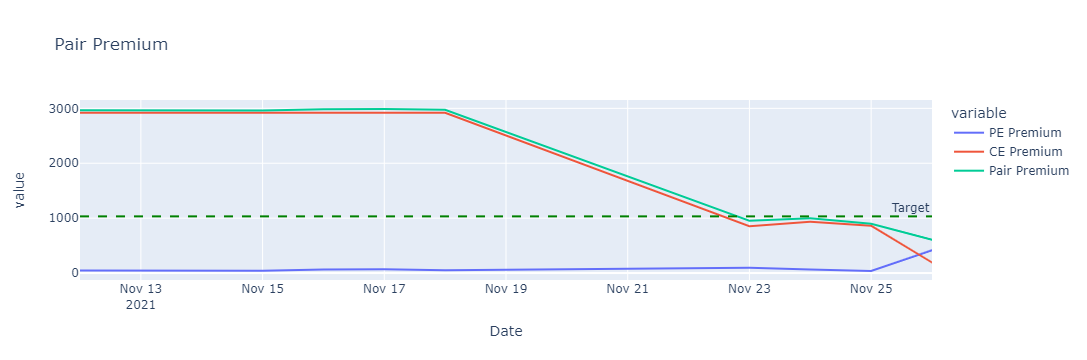

In [90]:
fig = px.line(pair_historical.dropna().reset_index(), x="Date", y=["PE Premium", "CE Premium", "Pair Premium"], title="Pair Premium")
fig.add_hline((1+target)*pair_position['cost']/pair_position['quantity'], line_dash="dash", line_color="green", annotation_text='Target')
fig.show()

# Kelly Criterion

Against losing on all pairs

In [93]:
import  numpy as np

### Capital Allocation

Not considering partial losses

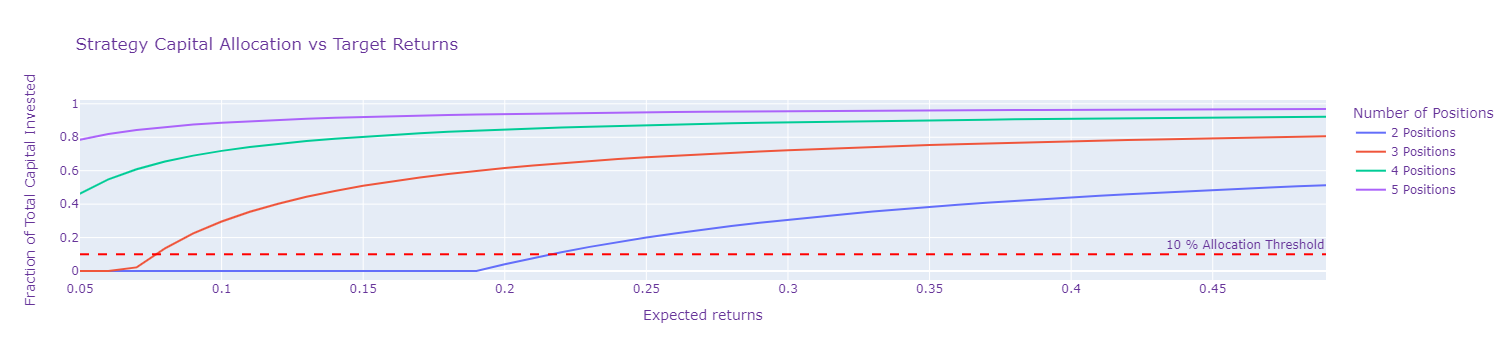

In [145]:
expected_gain_range = np.arange(0.05, 0.5, 0.01)

position_range = np.arange(2, 6)

p_not_breakeven = 0.4
# num_positions = 2
fig = go.Figure()
for num_positions in position_range:
    
    p = 1 - p_not_breakeven**num_positions
    gain_fraction_df =  pd.DataFrame({"Capital Fraction":np.apply_along_axis(lambda expected_gain: p -  (1-p) / expected_gain, 0, expected_gain_range),
                                  "Expected Gain":expected_gain_range})
    gain_fraction_df.loc[gain_fraction_df['Capital Fraction']<0, 'Capital Fraction'] = 0
    # gain_fraction_df.loc[gain_fraction_df['Capital Fraction'].gt(0.05).idxmax(), "Expected Gain"]

    fig.add_trace(go.Scatter(x=gain_fraction_df["Expected Gain"], y=gain_fraction_df["Capital Fraction"],
                    mode='lines',
                    name='%d Positions'%num_positions))
    
fig.add_hline(0.1, line_dash="dash", line_color="red", annotation_text='10 % Allocation Threshold')
fig.update_layout(
    title="Strategy Capital Allocation vs Target Returns",
    xaxis_title="Expected returns",
    yaxis_title="Fraction of Total Capital Invested",
    legend_title="Number of Positions",
    font=dict(
#         family="Courier New, monospace",
        size=12,
        color="RebeccaPurple"
    )
)

fig.show()

Considering partial losses : Loss of 1 position

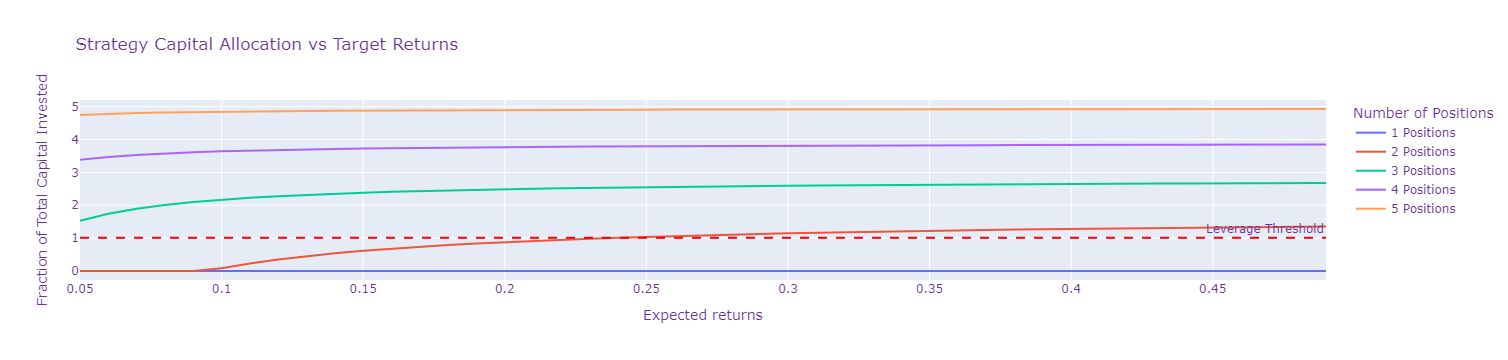

In [146]:
expected_gain_range = np.arange(0.05, 0.5, 0.01)

position_range = np.arange(1, 6)

p_not_breakeven = 0.4
# num_positions = 2
fig = go.Figure()
for num_positions in position_range:
    
    p = 1 - p_not_breakeven**num_positions
    gain_fraction_df =  pd.DataFrame({"Capital Fraction":np.apply_along_axis(lambda expected_gain: p/(1/num_positions) -  (1-p) / expected_gain, 0, expected_gain_range),
                                  "Expected Gain":expected_gain_range})
    gain_fraction_df.loc[gain_fraction_df['Capital Fraction']<0, 'Capital Fraction'] = 0
    # gain_fraction_df.loc[gain_fraction_df['Capital Fraction'].gt(0.05).idxmax(), "Expected Gain"]

    fig.add_trace(go.Scatter(x=gain_fraction_df["Expected Gain"], y=gain_fraction_df["Capital Fraction"],
                    mode='lines',
                    name='%d Positions'%num_positions))
    
fig.add_hline(1.01, line_dash="dash", line_color="red", annotation_text='Leverage Threshold')
fig.update_layout(
    title="Strategy Capital Allocation vs Target Returns",
    xaxis_title="Expected returns",
    yaxis_title="Fraction of Total Capital Invested",
    legend_title="Number of Positions",
    font=dict(
#         family="Courier New, monospace",
        size=12,
        color="RebeccaPurple"
    )
)

fig.show()

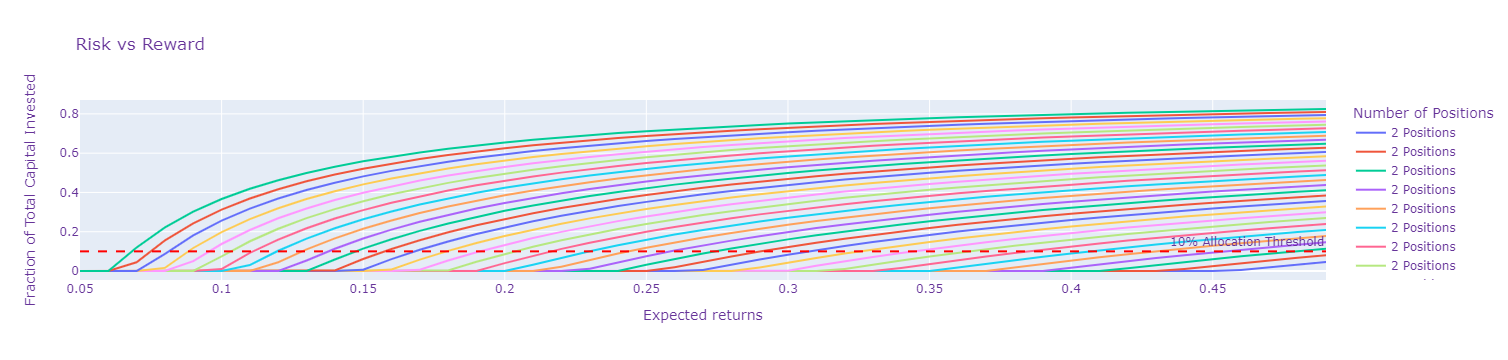

In [140]:
# p_not_breakeven = 0.4
# num_positions = 2
expected_gain = 0.1
position_range = np.arange(1, 6)
p_range = np.arange(0.56, 0.24, -0.01)
fig = go.Figure()
for p_not_breakeven in p_range:
    
    for num_positions in position_range:
    
        p = 1 - p_not_breakeven**num_positions
        p/(1/num_positions) - p_not_breakeven/
#     gain_fraction_df =  pd.DataFrame({"Capital Fraction":np.apply_along_axis(lambda expected_gain: p -  (1-p) / expected_gain, 0, expected_gain_range),
#                                   "Expected Gain":expected_gain_range})
#     gain_fraction_df.loc[gain_fraction_df['Capital Fraction']<0, 'Capital Fraction'] = 0
#     # gain_fraction_df.loc[gain_fraction_df['Capital Fraction'].gt(0.05).idxmax(), "Expected Gain"]

    fig.add_trace(go.Scatter(x=gain_fraction_df["Expected Gain"], y=gain_fraction_df["Capital Fraction"],
                    mode='lines',
                    name='%d Positions'%num_positions))
    
fig.add_hline(0.1, line_dash="dash", line_color="red", annotation_text='10% Allocation Threshold')
fig.update_layout(
    title="Risk vs Reward",
    xaxis_title="Expected returns",
    yaxis_title="Fraction of Total Capital Invested",
    legend_title="Number of Positions",
    font=dict(
#         family="Courier New, monospace",
        size=12,
        color="RebeccaPurple"
    )
)

fig.show()

The more pairs we hold